In [1]:

import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from neuralforecast import NeuralForecast
from sklearn import metrics
import os
plt.rcParams['font.family'] = 'Times New Roman'
############################################################################################################
def regCalculate(true, prediction):
    rmse = np.sqrt(metrics.mean_squared_error(true, prediction))
    mae = metrics.mean_absolute_error(true, prediction)
    mape = metrics.mean_absolute_percentage_error(true, prediction)
    r2 = metrics.r2_score(true, prediction)

    MetricsStruct = {'rmse': rmse, 'mae': mae, 'mape': mape, 'r2': r2}
    return MetricsStruct
############################################################################################################
def savePickle(path, data):
    with open(path, 'wb') as f:
        pickle.dump(data, f)
############################################################################################################
def predictLifespan(data, y_label, lifeDeclineInd = 0.1, stand_value = None):
    x_ticks = np.arange(len(data))
    if stand_value is None:
        stand_value = data.iloc[:10][y_label].mean()
    
    X = x_ticks
    y = data[y_label].values
    LR = LinearRegression(fit_intercept=True)
    LR.fit(X.reshape(-1,1), y)
    step_0 = X[-1] + 1
    step_1 = step_0 + 10
    in1 = 0
    while True:
        pred_range = np.arange(step_0, step_1)

        LR_pred = LR.predict(pred_range.reshape(-1, 1))
        if (stand_value - LR_pred[-1]) / stand_value > lifeDeclineInd or in1 > 30000:

            break
        else:
            step_1 = pred_range[-1] + 10
            in1 += 10

    result = np.concatenate((y, LR_pred))
    decay_period_years = step_1 / 365
    if in1>30000:
        return None, None
    return result, decay_period_years
############################################################################################################
def getResultDf(cv_df, modelName):
    cv_df = cv_df[[f'Auto{modelName}-median', f'Auto{modelName}-lo-95',f'Auto{modelName}-hi-95']]
    cv_df.rename(columns={f'Auto{modelName}-median': modelName, f'Auto{modelName}-lo-95': 'Lower',f'Auto{modelName}-hi-95': 'Upper'}, inplace=True)
    
    return cv_df
############################################################################################################

d:\anaconda\envs\pytorch_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-10-10 20:24:01,044	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-10-10 20:24:01,260	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [2]:
fileNmae = 'No.3'
filePath = f'./data/{fileNmae}/processDailyData.pkl'
ifSave = True
##导入刚刚处理的数据
with open(filePath, 'rb') as f:
	data = pickle.load(f)
ds_values = data[['ds']].copy()

In [3]:
data['ds'] = data.index.values
data = data[['ds','y_corrected']].rename(columns={'y_corrected': 'y'})
data.insert(loc=0, column='unique_id', value='timeseries_1')
data.head()

,unique_id,ds,y
0,timeseries_1,0,142.842874
1,timeseries_1,1,142.840522
2,timeseries_1,2,142.864779
3,timeseries_1,3,142.861213
4,timeseries_1,4,142.871066


In [4]:
## 选择模型，这里选用 TCN 神经网络模型
modelName = 'TCN'
modelPath = f'./sourceModel/{modelName}/bestModel'
savePath = f'./result/{modelName}/'

nf = NeuralForecast.load(path = modelPath)
if modelName != 'MLP':
	for param in nf.models[0].parameters():
		param.requires_grad = False

	last_layer_params = list(nf.models[0].mlp_decoder.parameters())
	bias_param = last_layer_params[-1]
	bias_param.requires_grad = True

else:
	for param in nf.models[0].parameters():
		param.requires_grad = False
	for param in nf.models[0].out.parameters():
		param.requires_grad = True
nf.models[0].learning_rate = 0.00001
nf.fit(df=data)
Y_hat_insample = nf.predict_insample(step_size=1)
cv_df = getResultDf(Y_hat_insample, modelName)
pred_metrics = regCalculate(data['y'].iloc[1:], cv_df[modelName].iloc[1:])

d:\anaconda\envs\pytorch_env\Lib\site-packages\neuralforecast\common\_base_model.py:444: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  content = torch.load(f, **kwargs)
Seed

d:\anaconda\envs\pytorch_env\Lib\site-packages\neuralforecast\core.py:210: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
C:\Users\TroubleMo\AppData\Local\Temp\ipykernel_480\3991875474.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cv_df.rename(columns={f'Auto{modelName}-median': modelName, f'Auto{modelName}-lo-95': 'Lower',f'Auto{modelName}-hi-95': 'Upper'}, inplace=True)


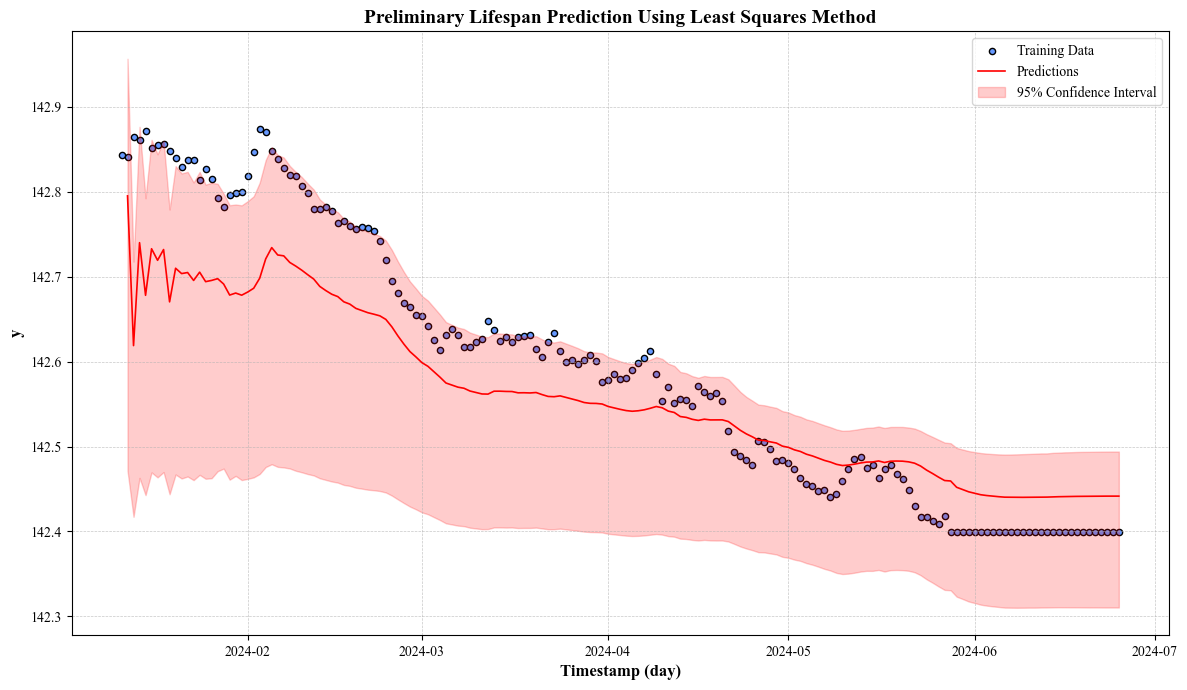

In [5]:
fig, ax = plt.subplots(figsize=(12, 7))
ax.scatter(ds_values['ds'], data['y'], marker='o', facecolors="#6699FF", edgecolors='black', alpha=1, s=20,  label='Training Data')
ax.plot(ds_values['ds'].iloc[1:], cv_df[modelName].iloc[1:], linestyle='-',color='red', linewidth=1.2, label='Predictions',zorder=4)
ax.fill_between(ds_values['ds'].iloc[1:], cv_df['Lower'].iloc[1:], cv_df['Upper'].iloc[1:],
				alpha=0.2, color='red', label='95% Confidence Interval', zorder=1)

ax.set_xlabel('Timestamp (day)', fontsize=12,fontweight='bold')
ax.set_ylabel('y', fontsize=12,fontweight='bold')
ax.set_title('Preliminary Lifespan Prediction Using Least Squares Method', fontsize=14, fontweight='bold')
ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
ax.legend()
plt.tight_layout()
if ifSave:
	os.makedirs(savePath, exist_ok=True)
	fig.savefig(f'{savePath}fig.png', dpi=300)
plt.show() 

In [6]:
_,decay_period_years = predictLifespan(cv_df, modelName, lifeDeclineInd = 0.1)
print('TWTs lifespan: ', decay_period_years)
print(pred_metrics)

TWTs lifespan:  21.567123287671233
{'rmse': 0.07291716460464391, 'mae': 0.060155186392326435, 'mape': 0.00042161531365446673, 'r2': 0.7767407467182974}


In [7]:
resultSave = {"pred":cv_df,"predMetrics": pred_metrics, "lifeSpan": decay_period_years}
if ifSave:
	savePickle(f'{savePath}{modelName}_result.pkl', resultSave)